# imports

In [59]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import pdfplumber
from typing import TypedDict
import json
from langchain_groq import ChatGroq

In [51]:
load_dotenv()

True

# Define state types

In [40]:
class ExtractTextFromPDFState(TypedDict):
    file_path: str
    resume_text: str

class ResumeAnalyserState(ExtractTextFromPDFState):
    JD_text: str
    resume_rating: float
    resume_jd_match: float
    analysis: str

# Extract text from pdf

In [41]:
def extract_text_from_pdf(state: ExtractTextFromPDFState) -> ExtractTextFromPDFState:
    try:
        with pdfplumber.open(state['file_path']) as pdf:
            text = "\n".join(
                [page.extract_text() for page in pdf.pages if page.extract_text()]
            )
        state['resume_text'] = text.strip() if text else "[NO TEXT EXTRACTED]"
    except Exception as e:
        state['resume_text'] = f"[ERROR] Failed to parse PDF: {str(e)}"
    return state

In [42]:
path = "./files/BISWAJIT AICH RESUME.pdf"

# Setup llm

In [73]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=1.0,
    max_tokens=1024
)
message = """
You are an expert resume analyser. You will be given a resume and a job description.
Your task is to rate the resume on a scale of 1 to 5 based on its relevance to the job description.
You will also provide a match score between the resume and the job description on a scale of 0 to 1.
Finally, you will provide a brief analysis of the resume.
Return the results in the following json format only (without any additional text):
{{
    "resume_rating": <rating>,
    "resume_jd_match": <match_score>,
    "analysis": "<analysis>"
}}
___
'resume_text': '{resume_text}',
'JD_text': '{JD_text}'
"""

In [69]:
def llm_response(state: ResumeAnalyserState) -> ResumeAnalyserState:
    resume_text = state['resume_text']
    jd_text = state['JD_text']
    
    prompt = message.format(resume_text=resume_text, JD_text=jd_text)
    response = llm.invoke(prompt)

    try:
        parsed = json.loads(response.content.strip())
        state['resume_rating'] = parsed.get("resume_rating", -1)
        state['resume_jd_match'] = parsed.get("resume_jd_match", -1.0)
        state['analysis'] = parsed.get("analysis", "No analysis provided.")
    except Exception as e:
        state['resume_rating'] = -1
        state['resume_jd_match'] = -1
        state['analysis'] = f"[ERROR] Failed to parse LLM response: {str(e)}\nRaw: {response.content}"

    return state

# Setup LangGraph

In [71]:
graph = StateGraph(ResumeAnalyserState)

graph.add_node('extract_text_from_pdf', extract_text_from_pdf)
graph.add_node('llm_response', llm_response)

graph.add_edge(START, 'extract_text_from_pdf')
graph.add_edge('extract_text_from_pdf', 'llm_response')
graph.add_edge('llm_response', END)

workflow = graph.compile()

# Test run

In [72]:
initial_input = {
    "file_path": "./files/BISWAJIT AICH RESUME.pdf",
    "JD_text": "We are hiring a full-stack engineer with React and Node.js experience.",
    "resume_rating": -1,
    "resume_jd_match": -1,
    "analysis": "No analysis done yet.",
}
result = workflow.invoke(initial_input)

print(result)
print("\n")
print(f"Rating: {result['resume_rating']}")
print(f"JD Match: {result['resume_jd_match']}")
print(f"Analysis: {result['analysis']}")

{'file_path': './files/BISWAJIT AICH RESUME.pdf', 'resume_text': 'BISWAJIT AICH\nAspiring Computer Science Engineer | AI/ML Enthusiast | Full-Stack Developer\nLocation: Hooghly, West Bengal, India Date of Birth: 22 September 2002\nEmail: biswajitaichofficial@gmail.com Phone: +916290675574\nPortfolio: http://biswajitaichportfolio.vercel.app GitHub: https://github.com/BiswajitAich\n1. PROFESSIONAL SUMMARY\nComputer science engineering student with a love for the field and over 2 years of hands-on experience in\nAI/ML and web development. Put more than 4 AI models to work in real-world settings making backend\nAPIs run smoother and boosting user satisfaction. Build using full stack.\n2. EDUCATION\nBachelor of Technology in Computer Science and Engineering 2022- Present\nAcademy of Technology, MAKAUT University, Adisaptagram, West Bengal, India\nHigher Secondary Education 2020-2022\nVivekananda English Academy, WBBHSE, Rishra, West Bengal, India\nSecondary Education 2018-2020\nVivekananda 

# Visualize

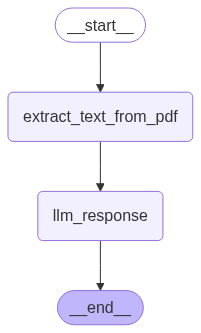

In [74]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())